In [2]:
import import_ipynb
from ConsistencyIndexes import *
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from IPython.display import clear_output
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch import nn

importing Jupyter notebook from ConsistencyIndexes.ipynb
importing Jupyter notebook from Functions.ipynb


# DNN Architecture

Loss Function:<br>
<center>$L = \left(T-\sum_{i=0}^{N} W_i*Conv(I,K_i)\right)^2$</center><br>
Where:<br>
<ul>
    <li><b>$T$</b> is the target image.
    <li><b>$I$</b> is the original image.
    <li><b>$N$</b> is the number of kernels and weights.
    <li><b>$K_i$</b> is the ith kernel.
    <li><b>$W_i$</b> is the weight for the kernel $K_i$.
    <li><b>$Conv$</b> is the convolution function.

In [3]:
# Function to create convolutional kernels and weights
def create_kernels_weights(num_kernels, kernel_size):
    # Create kernels with 3 output channels instead of 1
    kernels = [torch.rand(3, 3, kernel_size, kernel_size, requires_grad=True) for _ in range(num_kernels)]
    weights = [torch.randn(1) for _ in range(num_kernels)]
    return kernels, weights

# Function to perform convolution and compute the weighted sum
def apply_kernels(input_image, kernels, weights):
    # Perform convolution with 3-channel output and sum results
    output = sum(weights[i] * F.conv2d(input_image, kernels[i], padding=kernels[i].shape[-1]//2) for i in range(len(kernels)))
    return output

# Function to apply kernels and display the result
def predict_and_display(input_image, kernels, weights):
    input_image = torch.tensor(input_image, dtype=torch.float32).permute(2,0,1).unsqueeze(0)
    with torch.no_grad():
        output_image = apply_kernels(input_image, kernels, weights)
    return output_image.squeeze(0).permute(1,2,0).cpu().numpy().astype(np.uint8)

# Main function
def train_model(input_images, target_images, num_kernels, kernel_size=3, epochs=100, lr=0.01):
    oimg = input_images.copy()
    L = []
    # Normalize input and target images (to 0-1)
    input_images = [img / 255.0 for img in input_images]
    target_images = [img / 255.0 for img in target_images]    
    # Convert input and target images to tensors
    input_images = torch.stack([torch.tensor(img, dtype=torch.float32) for img in input_images])
    target_images = torch.stack([torch.tensor(img, dtype=torch.float32) for img in target_images])  
    #Initialize kernels and weights
    kernels, weights = create_kernels_weights(num_kernels, kernel_size)
    # Define optimizer
    optimizer = optim.Adam(kernels+weights, lr=lr)
    # Training loop
    for epoch in range(epochs):
        total_loss = 0.0
        cv2.imshow('I', np.clip(predict_and_display(oimg[0],kernels,weights),0,255))  #Display Image
        for input_image, target_image in zip(input_images, target_images):
            input_image = input_image.permute(2,0,1).unsqueeze(0)  # Add batch dimension
            target_image = target_image.permute(2,0,1).unsqueeze(0)         
            optimizer.zero_grad()   
            output_image = apply_kernels(input_image, kernels, weights)
            loss = mse_loss(output_image, target_image)
            loss.backward()
            optimizer.step()          
            total_loss += loss.item() 
        L.append(total_loss)
        # Print epoch and loss
        clear_output(wait=True)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(input_images):.4f}') 
        cv2.waitKey(10) #Press any key to stop displaying
    print('Training complete.')
    cv2.destroyAllWindows()
    return kernels, weights,L

In [4]:
cap = open_vid("VDB/puppies.mp4")
org = get_frames(cap)
cap = open_vid("Cartoonized/puppiestoon.mp4")
car = get_frames(cap)

In [5]:
len(org),len(car)

(1152, 100)

In [6]:
limit = 20#len(car)
# Example usage:
# Assuming input_images and target_images are lists of PyTorch tensors with shape [C, H, W]
kernels, weights, Losses = train_model(org[:limit], car[:limit], num_kernels=5,epochs=100, lr=1e-3)

Epoch [100/100], Loss: 0.0437
Training complete.


In [7]:
kernels

[tensor([[[[-0.1809,  0.0268,  0.0628],
           [ 0.3375,  0.0148, -0.0330],
           [ 0.2404,  0.4742,  0.1381]],
 
          [[ 0.2211, -0.0498,  0.3629],
           [ 0.1284, -0.0408,  0.3324],
           [ 0.0559,  0.2763, -0.1645]],
 
          [[ 0.0480, -0.0421,  0.1987],
           [ 0.0542, -0.4664, -0.1059],
           [ 0.0435,  0.3583,  0.4387]]],
 
 
         [[[ 0.2920, -0.4935, -0.1458],
           [-0.2950, -0.3822, -0.3274],
           [-0.0765, -0.1900, -0.0238]],
 
          [[-0.2472, -0.4840, -0.1479],
           [ 0.3557, -0.2474,  0.1997],
           [ 0.4505,  0.3360, -0.2654]],
 
          [[ 0.1712, -0.0403,  0.0046],
           [-0.3222, -0.4214, -0.1689],
           [-0.0094, -0.2466, -0.4497]]],
 
 
         [[[ 0.1302, -0.5190, -0.1458],
           [ 0.0902, -0.5031,  0.2496],
           [-0.2639,  0.0266, -0.3086]],
 
          [[-0.0800, -0.1677,  0.3827],
           [ 0.0608,  0.0226, -0.1720],
           [-0.4535, -0.0450,  0.0674]],
 
          

In [8]:
weights

[tensor([-1.0434]),
 tensor([-1.0530]),
 tensor([-0.5466]),
 tensor([-1.6035]),
 tensor([-0.8413])]

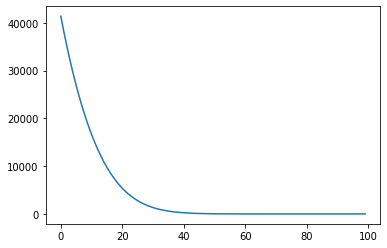

In [9]:
plt.plot(Losses)

In [12]:
Predicted = [predict_and_display(o,kernels,weights) for o in org[:100]]

In [16]:
ThroughFrames(Predicted)